# Gaussian Discriminant Analysis

In [1]:
# Load all relevant modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for statistical data visualization
import pandas as pd

import os
import sys
import imp

from scipy import stats

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import datasets as D
imp.reload(D)

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_23202/1933994762.py:9: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'datasets' from '/Users/mghifary/Work/Code/AI/IF6080/datasets.py'>

### Data Processing

In [2]:
# Constants
DATADIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data')

In [3]:
# Load dataset
df, X, y = D.load_breast_cancer()

In [4]:
df.tail()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [5]:
# Split training - val dataset
[n, d] = X.shape
n_train = int(0.7 * n)
n_val = n - n_train
print(n_train, n_val)

X_train = X[:n_train, :]
y_train = y[:n_train]

X_val = X[n_train:, :]
y_val = y[n_train:]

398 171


In [6]:
# Check train-val label distribution
counts_train, _ = np.histogram(y_train, bins=2)
counts_val,  _ = np.histogram(y_val, bins=2)

(array([132.,   0.,  39.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

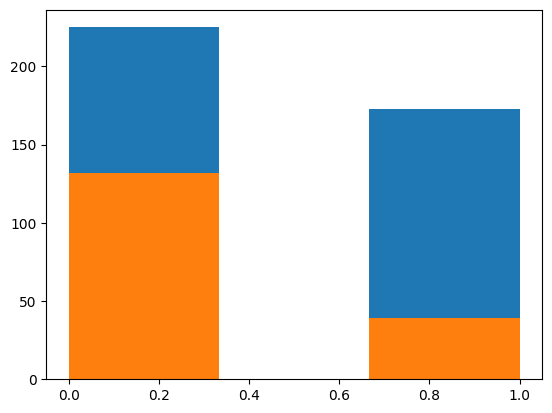

In [7]:
plt.hist([0, 1], bins=3, weights=counts_train)
plt.hist([0, 1], bins=3, weights=counts_val)

### Model Training

In [8]:
def fit(X, y):
    n = len(y)

    n1 = np.sum(y == 1)
    n0 = n - n1

    phi = n1 / n

    idx1, = np.where(y == 1)
    mu1 = np.mean(X[idx1], axis=0)

    idx0, = np.where(y == 0)
    mu0 = np.mean(X[idx0], axis=0)

    D1 = X[idx1] - mu1
    Cov1 = (D1.T @ D1) / n

    D0 = X[idx0] - mu0
    Cov0 = (D0.T @ D0) / n

    Cov = Cov1 + Cov0

    return mu1, mu0, Cov, phi


def predict(x, mu1, mu0, Cov, phi):
    proba_xy1 = stats.multivariate_normal.pdf(x, mu1, Cov, allow_singular=True)

    proba_xy0 = stats.multivariate_normal.pdf(x, mu0, Cov, allow_singular=True)

    proba_yx1 = proba_xy1 * phi
    proba_yx0 = proba_xy0 * (1-phi)

    proba = proba_yx1 / (proba_yx1 + proba_yx0)

    y_hat = (proba >= 0.5).astype(np.uint)
    return y_hat, proba

In [9]:
# Training
mu1, mu0, Cov, phi = fit(X_train, y_train)

In [10]:
# Prediction
y_train_hat, proba_train = predict(X_train, mu1, mu0, Cov, phi)
y_val_hat, proba_val = predict(X_val, mu1, mu0, Cov, phi)

In [11]:
def accuracy(y, y_hat):
    """
    Args:
        y:
        y_hat:
    """
    acc = np.sum(y == y_hat) / len(y)
    return acc

# Check accuracy
train_acc = accuracy(y_train, y_train_hat) * 100.
val_acc = accuracy(y_val, y_val_hat) * 100.

print(f"Accuracy: (training = {train_acc:.2f}, validation: {val_acc:.2f})")

Accuracy: (training = 96.48, validation: 98.25)


In [12]:
np.diag(Cov)

array([6.15446060e+00, 1.25779088e+01, 2.80564612e+02, 6.61650412e+04,
       1.64886681e-04, 1.92974772e-03, 3.74443758e-03, 6.67664889e-04,
       7.23161828e-04, 5.23517908e-05, 5.28623242e-02, 2.89835434e-01,
       2.91198604e+00, 1.31142386e+03, 9.37625074e-06, 3.41909912e-04,
       1.06961842e-03, 3.56635860e-05, 8.19549695e-05, 8.34141250e-06,
       9.98831482e+00, 2.63064393e+01, 4.66583412e+02, 1.61673042e+05,
       4.30889896e-04, 1.77757503e-02, 2.61758011e-02, 1.66568972e-03,
       3.67383679e-03, 3.19271437e-04])

<Axes: >

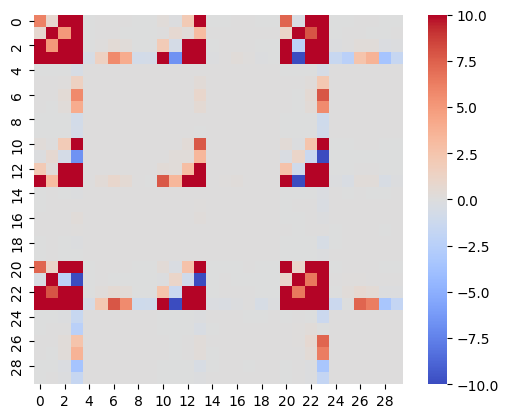

In [13]:
# Plot covariance matrix
sns.heatmap(Cov, cmap='coolwarm', vmin=-10, vmax=10, square=True)

In [14]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_hat)

print(f"Confusion matrix (training):")
print(cm_train)

cm_val = confusion_matrix(y_val, y_val_hat)
print(f"Confusion matrix (validation):")
print(cm_val)

Confusion matrix (training):
[[224   1]
 [ 13 160]]
Confusion matrix (validation):
[[131   1]
 [  2  37]]


# Logistic Regression
As a comparison, we check the performance of logistic regression on breast cancer dataset

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
clf = LogisticRegression(random_state=0)

In [17]:
clf.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [18]:
# calculate accuracy after training
y_train_hat = clf.predict(X_train)
y_val_hat = clf.predict(X_val)
train_acc = accuracy(y_train, y_train_hat)
val_acc = accuracy(y_val, y_val_hat)
print(f"[sklearn: Logistic Regression] train accuracy: {train_acc:.2f}, validation accuracy: {val_acc:.2f}")

[sklearn: Logistic Regression] train accuracy: 0.96, validation accuracy: 0.93


In [19]:
cm_train = confusion_matrix(y_train, y_train_hat)

print(f"Confusion matrix (training):")
print(cm_train)

cm_val = confusion_matrix(y_val, y_val_hat)
print(f"Confusion matrix (validation):")
print(cm_val)

Confusion matrix (training):
[[218   7]
 [  8 165]]
Confusion matrix (validation):
[[121  11]
 [  1  38]]
